# ResNet 직접구현

In [3]:
# 파이토치
import torch
import torch.nn.functional as F
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정하기
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
plt.rc('font', family='NanumBarunGothic')
matplotlib.font_manager._rebuild()

## ResNet 직접구현 코드

In [4]:
class BasicBlock(nn.Module):
	# mul은 추후 ResNet18, 34, 50, 101, 152등 구조 생성에 사용됨
    mul = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()
        
        # stride를 통해 너비와 높이 조정
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        
        # stride = 1, padding = 1이므로, 너비와 높이는 항시 유지됨
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        # x를 그대로 더해주기 위함
        self.shortcut = nn.Sequential()
        
        # 만약 size가 안맞아 합연산이 불가하다면, 연산 가능하도록 모양을 맞춰줌
        if stride != 1: # x와 
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x) # 필요에 따라 layer를 Skip
        out = F.relu(out)
        return out

In [5]:
class BottleNeck(nn.Module):
	# 논문의 구조를 참고하여 mul 값은 4로 지정, 즉, 64 -> 256
    mul = 4
    def __init__(self, in_planes, out_planes, stride=1):
        super(BottleNeck, self).__init__()
        
        #첫 Convolution은 너비와 높이 downsampling
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        self.conv3 = nn.Conv2d(out_planes, out_planes*self.mul, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes*self.mul)
        
        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_planes != out_planes*self.mul:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes*self.mul, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes*self.mul)
            )
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
	# CIFAR-10을 학습시킬 것이므로, num_classes=10으로 설정
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        #RGB 3개채널에서 64개의 Kernel 사용 (논문 참고)
        self.in_planes = 64
        
        # Resnet 논문 구조의 conv1 파트 그대로 구현
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding = 3)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        # Basic Resiudal Block일 경우 그대로, BottleNeck일 경우 4를 곱한다.
        self.linear = nn.Linear(512 * block.mul, num_classes)
        
    # 다양한 Architecture 생성을 위해 make_layer로 Sequential 생성     
    def make_layer(self, block, out_planes, num_blocks, stride):
        # layer 앞부분에서만 크기를 절반으로 줄이므로, 아래와 같은 구조
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, out_planes, strides[i]))
            self.in_planes = block.mul * out_planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.linear(out)
        return out

In [7]:
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])
def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])
def ResNet50():
    return ResNet(BottleNeck, [3, 4, 6, 3])
def ResNet101():
    return ResNet(BottleNeck, [3, 4, 23, 3])
def ResNet152():
    return ResNet(BottleNeck, [3, 8, 36, 3])

## ResNet 직접구현

In [28]:
# Simple Learning Rate Scheduler
def lr_scheduler(optimizer, epoch):
    lr = learning_rate
    if epoch >= 50:
        lr /= 10
    if epoch >= 100:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Xavier         
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [29]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = '/content/drive/MyDrive/Colab Notebooks/1조/image'
data_dir = '/content/drive/MyDrive/check'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_dataset))
print('테스트 데이터셋 크기:', len(test_dataset))

class_names = train_dataset.classes
print('클래스:', class_names)

학습 데이터셋 크기: 379
테스트 데이터셋 크기: 60
클래스: ['hat', 'jeans', 'labtop']


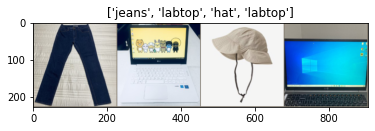

In [30]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_loader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [31]:
model = ResNet34()
model.apply(init_weights)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  


In [32]:
num_epochs = 2 #50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 1.9821 Acc: 42.2164% Time: 3.6548s
#1 Loss: 1.2412 Acc: 51.1873% Time: 7.2912s


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


[예측 결과: jeans] (실제 정답: jeans)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0, flags=flags)


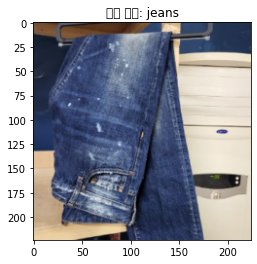

[예측 결과: labtop] (실제 정답: labtop)


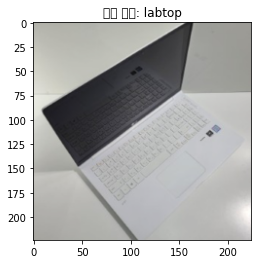

[예측 결과: labtop] (실제 정답: hat)


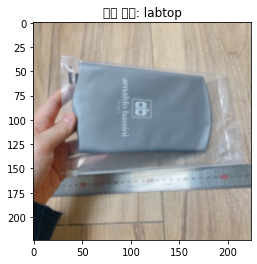

[예측 결과: labtop] (실제 정답: hat)


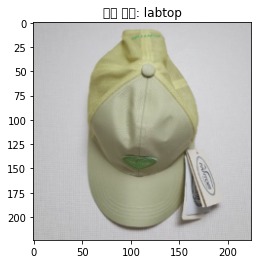

[예측 결과: labtop] (실제 정답: jeans)


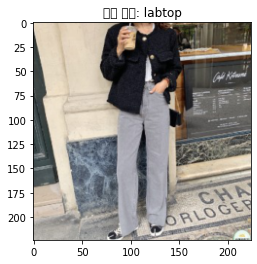

[예측 결과: labtop] (실제 정답: labtop)


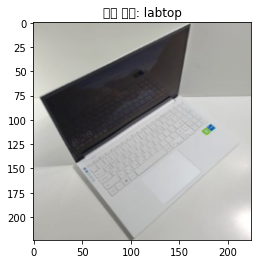

[예측 결과: labtop] (실제 정답: labtop)


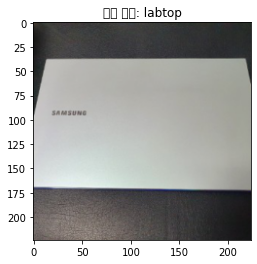

[예측 결과: jeans] (실제 정답: jeans)


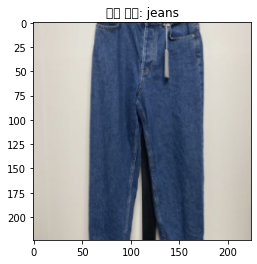

[예측 결과: labtop] (실제 정답: labtop)


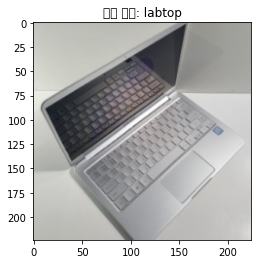

[예측 결과: jeans] (실제 정답: jeans)


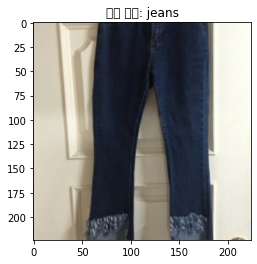

[예측 결과: labtop] (실제 정답: labtop)


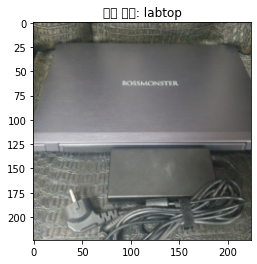

[예측 결과: labtop] (실제 정답: labtop)


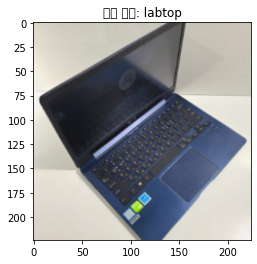

[예측 결과: labtop] (실제 정답: hat)


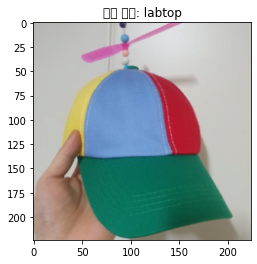

[예측 결과: labtop] (실제 정답: hat)


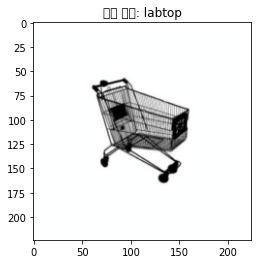

[예측 결과: labtop] (실제 정답: hat)


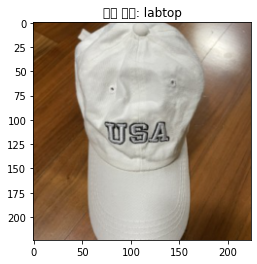

[Test Phase] Loss: 1.6984 Acc: 51.6667% Time: 3.8599s


In [35]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

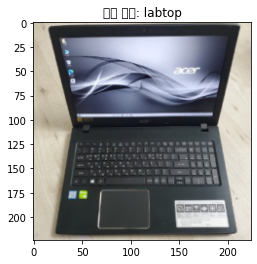

In [36]:
from PIL import Image


image = Image.open('/content/drive/MyDrive/Colab Notebooks/1조/image/c_226.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

## ResNet34 모델사용

In [37]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# data_dir = '/content/drive/MyDrive/Colab Notebooks/1조/image'
data_dir = '/content/drive/MyDrive/check'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 379
테스트 데이터셋 크기: 60
클래스: ['hat', 'jeans', 'labtop']


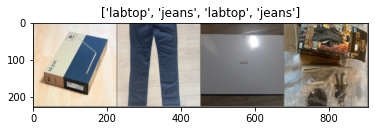

In [38]:
def imshow(input, title):
    # torch.Tensor를 numpy 객체로 변환
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제하기
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 출력
    plt.imshow(input)
    plt.title(title)
    plt.show()


# 학습 데이터를 배치 단위로 불러오기
iterator = iter(train_dataloader)

# 현재 배치를 이용해 격자 형태의 이미지를 만들어 시각화
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In [39]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 46개로 교체하여 마지막 레이어 다시 학습

# model.fc = nn.Linear(num_features, 46)
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [40]:
num_epochs = 2 #50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.5324 Acc: 78.3641% Time: 3.5189s
#1 Loss: 0.3378 Acc: 87.5990% Time: 6.8487s


[예측 결과: labtop] (실제 정답: labtop)


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

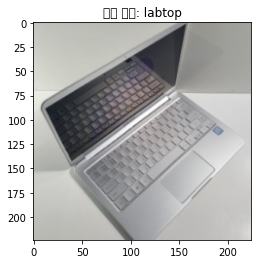

[예측 결과: hat] (실제 정답: hat)


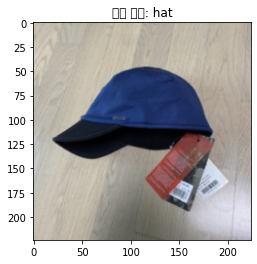

[예측 결과: labtop] (실제 정답: labtop)


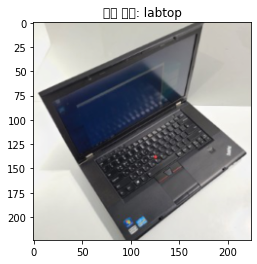

[예측 결과: labtop] (실제 정답: labtop)


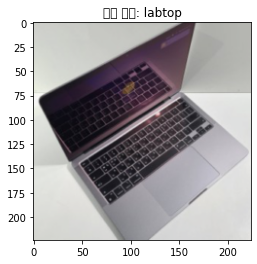

[예측 결과: hat] (실제 정답: hat)


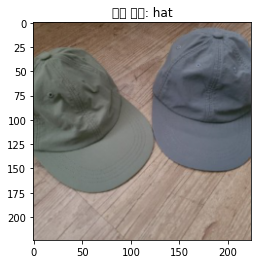

[예측 결과: labtop] (실제 정답: labtop)


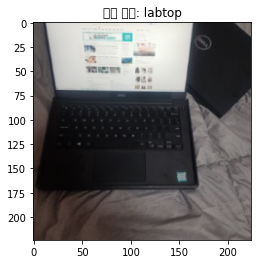

[예측 결과: labtop] (실제 정답: labtop)


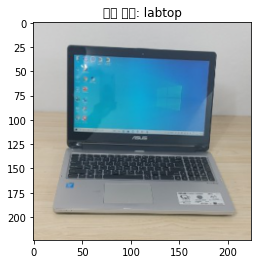

[예측 결과: jeans] (실제 정답: jeans)


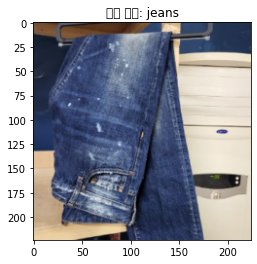

[예측 결과: jeans] (실제 정답: jeans)


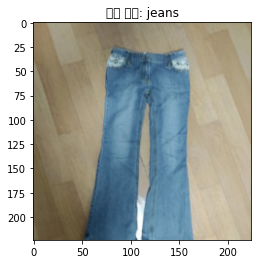

[예측 결과: hat] (실제 정답: hat)


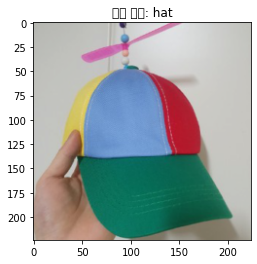

[예측 결과: labtop] (실제 정답: labtop)


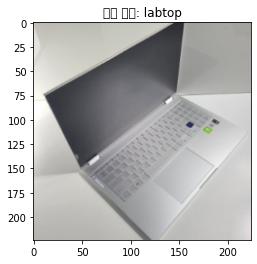

[예측 결과: jeans] (실제 정답: jeans)


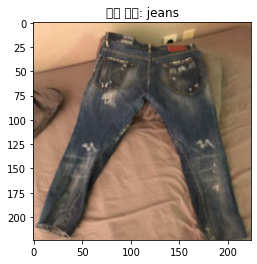

[예측 결과: labtop] (실제 정답: labtop)


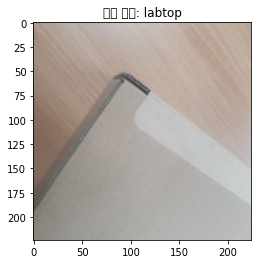

[예측 결과: jeans] (실제 정답: jeans)


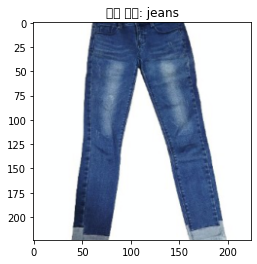

[예측 결과: labtop] (실제 정답: labtop)


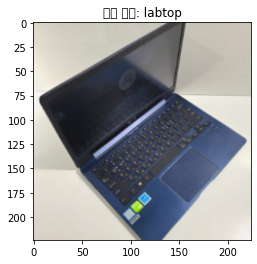

[Test Phase] Loss: 0.2823 Acc: 93.3333% Time: 3.8051s


In [41]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_te

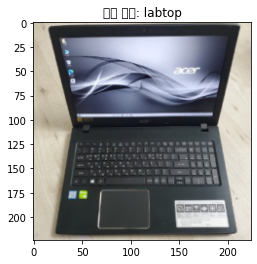

In [42]:
from PIL import Image


image = Image.open('/content/drive/MyDrive/Colab Notebooks/1조/image/c_226.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])